# CellNet

In [1]:

# after experiment successful, summarize findings in respective ipynb and integrate into defaults
experiments = dict(
  default =     ('default', True), 
  draft =       ('epochs', 2),
  
  release1 =    ('release1', True),
  release1n =    ('release1n', True),
  release2 =    ('release2', True),
  release2n =    ('release2n', True),
  release3 =    ('release3', True),
  release3n =    ('release3n', True),
  release4 =    ('release4', True),
  release4n =    ('release4n', True),

  architecture = ('model_architecture', ['smp.Unet', 'smp.Unet:attention', 'smp.UnetPlusPlus']),  # NOTE: 'smp.Unet:deeper' fails, likely due to a bug in smp :[
  encoder_all =     ('model_encoder', ['resnet34', 'resnext50_32x4d', 'timm-resnest50d', 'timm-res2net50_26w_4s', 'timm-regnetx_064', 'timm-gernet_l', 'se_resnext50_32x4d', 'timm-skresnext50_32x4d', 'densenet161', 'xception', 'timm-efficientnet-b5', 'timm-mobilenetv3_large_100', 'dpn68b', 'vgg19_bn', 'mit_b2', 'mobileone_s4']),
  encoder_adaptedbestsmall =     ('model_encoder', ['resnet152', 'resnet34', 'timm-efficientnet-b5', 'timm-mobilenetv3_large_100', 'timm-resnest50d', 'xception', 'vgg19_bn']),
  encoder_big = ('model_encoder', ['resnet152', 'timm-efficientnet-l2', 'timm-efficientnet-b8', 'timm-mobilenetv3_large_100', 'timm-resnest200e', 'timm-resnest269e', 'inceptionresnetv2', 'inceptionv4', 'xception', 'vgg19_bn']),
  xnorm_per_channel = ('xnorm_type', 'image_per_channel'),
##  rmbad =       ('rmbad', 0.1), ## DECRAP?
  loss =        ('lossf', ['MSE','BCE', 'MSE+BCE']), # 'KLD', 'MSE+BCE+KLD', 'Focal', 'MCC', 'Dice' Focal and MCC are erroneous (maybe logits vs probs). Dice is bad.  TODO Be inspired by arxiv:1907.02336
  # TODO: if linearcomb is better, then grid search weight
  sigma =       ('sigma', [3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]),
  fraction =    ('fraction', [0.1, 0.25, 0.5, 0.75, 0.875, 1.0]),
  sparsity =    ('sparsity', [0.1, 0.25, 0.5, 0.75, 0.875, 1.0]),
)

from json import decoder
from cellnet import data
import pandas as pd

data_quality = pd.read_csv('data/data_quality.csv', sep=r'\s+', index_col=0)

image_paths = [i for i in data.ls('data/images') if data_quality.loc[data.imgid(i), 'annotation_status'] in ('fully', 'sparse', 'empty')]
crossval_vals = '1 | 2 | QS_7510'# | QS_7415' # NOTE that with the empty image the accuracy formula breaks


import os, torch, json
from types import SimpleNamespace as obj

EXPERIMENT = os.getenv('EXPERIMENT', 'default')
CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if CUDA else 'cpu'); print('device =', device)

P, ps = experiments[EXPERIMENT]

modes = ['release', 'crossval', 'draft']
MODE = os.getenv('RELEASE_MODE', 'draft')
if MODE not in modes: MODE = 'crossval' 
# MODE undefined => interactive execution with draft; uknown custom tag defaults to crossval


if   MODE=='draft': data_splits = [(['data/images/1.jpg'], ['data/images/4.jpg'])]
elif MODE=='release': data_splits = [(image_paths, [])]
else: #MODE=='crossval': 
  crossval_vals = [s.split(' ') for s in crossval_vals.split(' | ')]
  data_splits = [([p for p in image_paths if data.imgid(p) not in vs], 
                  [p for p in image_paths if data.imgid(p)     in vs]) 
                  for vs in crossval_vals]
  

CFG = obj(**(dict(
  EXPERIMENT=EXPERIMENT,
  cropsize=256,
  batch_size=16,
  data_splits=data_splits,
  device=f'{device}',
  epochs=351,
  fraction=1, 
  image_paths=image_paths,
  lossf='MSE+BCE',
  lr_gamma=0.1,
  lr_steps=2.5,
  maxdist=26, 
  MODE=MODE,
  model_architecture='smp.UnetPlusPlus:attention',
  model_encoder='timm-mobilenetv3_large_100',
  param=P,
  rmbad=0,
  sigma=5.0,  # NOTE: do grid search again later when better convergence 
  sparsity=1,
  xnorm_params={},
  xnorm_type='imagenet',  # TODO: check 'image_per_channel' as well
  ) | {P: ps[-1] if type(ps) is list else ps}))

# NOTE quick hacks
if MODE=='release': 
  CFG.epochs=501

match EXPERIMENT:
  case 'release1':
    CFG.model_encoder = 'timm-mobilenetv3_large_100'

  case 'release1n':
    CFG.model_encoder = 'timm-mobilenetv3_large_100'
    CFG.xnorm_type = 'image_per_channel'

  case 'release2':
    CFG.model_encoder = 'timm-efficientnet-l2'
    CFG.cropsize = 256

  case 'release2n':
    CFG.model_encoder = 'timm-efficientnet-l2'
    CFG.xnorm_type = 'image_per_channel'
    CFG.cropsize = 256

  case 'release3':
    CFG.model_encoder = 'timm-efficientnet-b8'
  
  case 'release3n':
    CFG.model_encoder = 'timm-efficientnet-b8'
    CFG.xnorm_type = 'image_per_channel'


if 'draft' in CFG.__dict__ and CFG.draft is True: 
  CFG.epochs = 2
  #CFG.model_architecture = 'UNet'
  #CFG.model_encoder = 'resnet34'

import torch
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

import albumentations as A; from albumentations.pytorch import ToTensorV2

import os, json
from types import SimpleNamespace as obj
from statistics import mean, stdev

from cellnet.data import *
import cellnet.plot as plot
import cellnet.debug as debug
from cellnet.data import key2text

# save the config to disk
with open('cfg.json', 'w') as f:  f.write(json.dumps(CFG.__dict__, indent=2))

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


device = cuda:0


In [2]:

XNorm, CFG.xnorm_params = mk_XNorm(CFG, image_paths)

def mkAugs(mode):
  C = CFG.cropsize
  T = lambda ts:  A.Compose(transforms=[
    A.PadIfNeeded(C,C, border_mode=0, value=0),
    *ts,
    XNorm(), 
    A.PadIfNeeded(C,C, border_mode=0, value=0),
    ToTensorV2(transpose_mask=True, always_apply=True)], 
    keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True) 
  )

  vals = [A.D4(),
          ]

  return dict(
    test  = T([]),
    val   = T([A.RandomCrop(C,C, p=1),
               *vals]),
    train = T([A.RandomCrop(C,C, p=1),
               A.RandomBrightnessContrast(p=1, brightness_limit=0.25, contrast_limit=0.25),
               #A.RandomSizedCrop(p=1, min_max_height=(CROPSIZE//2, CROPSIZE*2), height=CROPSIZE, width=CROPSIZE),  # NOTE: issue with resize is that the keypoint sizes will not be updated
               #A.Rotate(),
               #A.AdvancedBlur(),
               #A.Equalize(),
               #A.ColorJitter(), 
               #A.GaussNoise(),
               *vals])
  )[mode]

In [3]:
if MODE=='draft' and not CUDA: 
  kp2hm, yunnorm, _ = mk_kp2mh_yunnorm(CFG)

  from math import prod
  def plot_grid(grid, **loader_kwargs):
    loader = mk_loader([CFG.image_paths[0]], cfg=CFG, bs=prod(grid), **loader_kwargs)
    B = next(iter(loader))
    B = batch2cpu(B, z=kp2hm(B))
    for b,ax in zip(B, plot.grid(grid, ([CFG.cropsize]*2))[1]):
      plot.overlay(b.x, b.z, b.m, b.k, b.l, CFG.sigma, ax=ax)

  plot_grid((3,3), transforms=mkAugs('val'))
  plot_grid((3,3), transforms=mkAugs('train'))

  for B in mk_loader(CFG.image_paths, cfg=CFG, bs=1, transforms=mkAugs('test'), shuffle=False):
    b = batch2cpu(B, z=kp2hm(B))[0]
    ax = plot.overlay(b.x, b.z, b.m, b.k, b.l, CFG.sigma)

In [4]:
plt.close('all')

import segmentation_models_pytorch as smp

mk_mk_model_smp = lambda cls, encoder_depth=5, **args: lambda cfg: cls(
  encoder_name=cfg.model_encoder, 
  encoder_weights=None,
  in_channels=3,
  classes=1,
  activation='sigmoid',
  encoder_depth=encoder_depth,
  decoder_channels=[16*2**d for d in range(encoder_depth)],
  **args
).to(device)

mk_model = lambda c: {
  'smp.Unet': mk_mk_model_smp(smp.Unet),
  'smp.Unet:attention': mk_mk_model_smp(smp.Unet, decoder_attention_type='scse'),
  'smp.Unet:deeper': mk_mk_model_smp(smp.Unet, encoder_depth=6),
  'smp.UnetPlusPlus': mk_mk_model_smp(smp.UnetPlusPlus),
  'smp.UnetPlusPlus:attention': mk_mk_model_smp(smp.UnetPlusPlus, decoder_attention_type='scse'),
}[c.model_architecture]

INFO: Because data/images/QS_7506.jpg is fully annotated or purposefully empty, fgmask is set to 1
INFO: Because data/images/QS_7508.jpg is fully annotated or purposefully empty, fgmask is set to 1
INFO: Because data/images/QS_7415.jpg is fully annotated or purposefully empty, fgmask is set to 1
INFO: Because data/images/QS_7510.jpg is fully annotated or purposefully empty, fgmask is set to 1


INFO: Because data/images/QS_7415.jpg is fully annotated or purposefully empty, fgmask is set to 1
INFO: Because data/images/QS_7506.jpg is fully annotated or purposefully empty, fgmask is set to 1
INFO: Because data/images/QS_7508.jpg is fully annotated or purposefully empty, fgmask is set to 1
INFO: Because data/images/QS_7510.jpg is fully annotated or purposefully empty, fgmask is set to 1


Training Loss
vi: . Epoch: 501, release3n: True


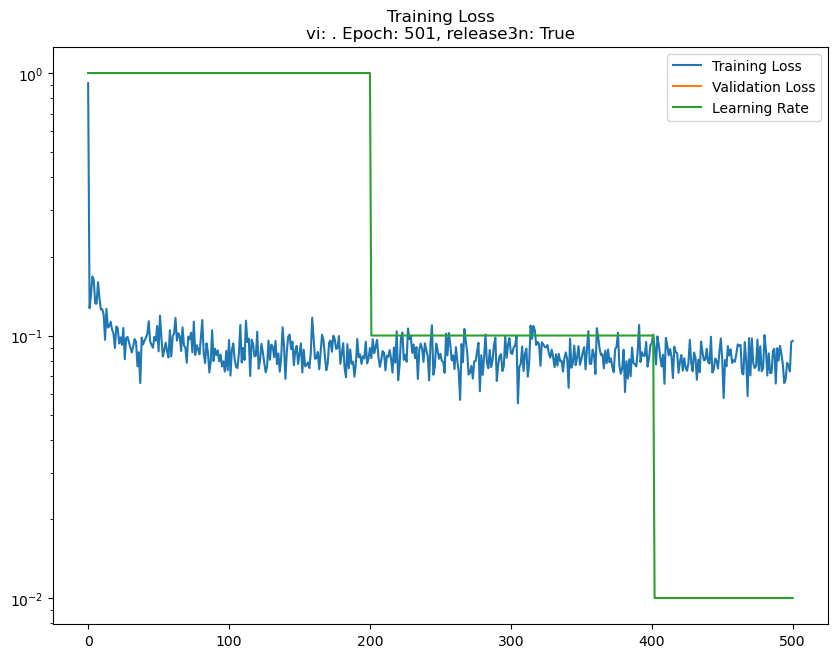

/gpfs/space/home/eckhardt/cellnet/results/train/240725-105848-release3n-release-RUNNING/cellnet/plot.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


/gpfs/space/home/eckhardt/cellnet/results/train/240725-105848-release3n-release-RUNNING/cellnet/plot.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


/gpfs/space/home/eckhardt/cellnet/results/train/240725-105848-release3n-release-RUNNING/cellnet/plot.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


INFO: Because data/images/QS_7415.jpg is fully annotated or purposefully empty, fgmask is set to 1


/gpfs/space/home/eckhardt/cellnet/results/train/240725-105848-release3n-release-RUNNING/cellnet/plot.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


INFO: Because data/images/QS_7506.jpg is fully annotated or purposefully empty, fgmask is set to 1


/gpfs/space/home/eckhardt/cellnet/results/train/240725-105848-release3n-release-RUNNING/cellnet/plot.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


INFO: Because data/images/QS_7508.jpg is fully annotated or purposefully empty, fgmask is set to 1


/gpfs/space/home/eckhardt/cellnet/results/train/240725-105848-release3n-release-RUNNING/cellnet/plot.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


INFO: Because data/images/QS_7510.jpg is fully annotated or purposefully empty, fgmask is set to 1


/gpfs/space/home/eckhardt/cellnet/results/train/240725-105848-release3n-release-RUNNING/cellnet/plot.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


In [5]:

# def count(y): return yunnorm(y).sum().item()
def accuracy(y,z): 
  ny, nz = y.sum().item(), z.sum().item()
  return 1 - abs(ny - nz) / (nz+1e-9)

def epoch(model, kp2hm, lossf, dl, optim=None):
  l = 0; a = 0; b = 0
  for B in dl:
    x,m = B['image'].to(device), B['masks'][0].to(device)
    z = kp2hm(B).to(device)

    y = model(x)
    loss = lossf(y*m, z*m) 
    l += loss.item()
    a += accuracy(y*m, z*m)
    b += 1

    if optim is not None:
      loss.backward()
      optim.step()
      optim.zero_grad()

  return l/b, a/b


results = pd.DataFrame()
if not MODE=='draft': [os.makedirs(_p, exist_ok=True) for _p in ('preds', 'plots')]

def training_run(cfg, traindl, valdl, kp2hm, model):
  global results  
  p = cfg.__dict__[P]
  ti = cfg.ti; vi = cfg.vi

  optim = torch.optim.Adam(model.parameters(), lr=5e-3)
  sched = torch.optim.lr_scheduler.StepLR(optim, step_size=int(cfg.epochs/cfg.lr_steps)+1, gamma=cfg.lr_gamma)
  losses = dict(
    MSE = torch.nn.MSELoss(),
    BCE = torch.nn.BCELoss(),
    Focal = smp.losses.FocalLoss('binary'),
    MCC = smp.losses.MCCLoss(),
    Dice = smp.losses.DiceLoss('binary', from_logits=False),
    KLD = torch.nn.KLDivLoss(reduction='batchmean'),  
  )
  lossfs = [losses[l] for l in cfg.lossf.split('+')]
  lossf = lambda y,z: sum([lf(y,z) for lf in lossfs])

  log = pd.DataFrame(columns='tl vl ta va lr'.split(' '), index=range(cfg.epochs))
  
  for e in range(cfg.epochs):
    log.loc[e,'lr'] = optim.param_groups[0]['lr']
  
    model.train()
    log.loc[e,'tl'], log.loc[e,'ta'] = epoch(model, kp2hm, lossf, traindl, optim)
    sched.step() 
  
    if valdl is not None: 
      model.eval()
      with torch.no_grad():
        log.loc[e,'vl'], log.loc[e,'va'] = epoch(model, kp2hm, lossf, valdl) 

    if MODE=='draft': plot.train_graph(e, log, info={P: p}, key2text=key2text, clear=True)
  plot.train_graph(cfg.epochs, log, info={P: p}, key2text=key2text, accuracy=False) 

  row = dict(**{P: p}, ti=ti, vi=vi, **log.iloc[-1])

  # compute loss distributions for a few batches 
  # NOTE DUPLICATE COMPUTATIOM is very inefficient since we already do it once batch_size times, which should suffice.. now again n_batches*batch_size times..
  @debug.timeit
  def evaluate_performance():
    tvla = 'tl vl ta va'.split(' ')
    model.eval()
    # edit last row of results
    for k in tvla: row[k] = []  # type: ignore
    for b in range(n_batches := 10): 
      tl, ta = epoch(model, kp2hm, lossf, traindl)
      vl, va = epoch(model, kp2hm, lossf, valdl) if valdl is not None else (float('nan'), float('nan'))
      for k,v in zip(tvla, [tl, vl, ta, va]): row[k].append(v) # type: ignore

    for k in tvla: 
      row[k+'_mean'] = np.array(row[k]).mean() # type: ignore
      row[k+'_std'] = np.array(row[k]).std() # type: ignore
  if MODE != 'draft': evaluate_performance()

  results = pd.DataFrame([row]) if results.empty else pd.concat([results, pd.DataFrame([row])], ignore_index=True)

  # DECRAP rmbad?
  @debug.timeit
  def loss_per_point_per_image():
    i2p2L = {}
    for i in vi: # only save the point losses for the validation image 
      B = next(iter(mk_loader([i], bs=1, transforms=mkAugs('test'), shuffle=False, cfg=cfg)))
      model.eval()
      with torch.no_grad(): y = cpu(model(B['image'].to(device)))
      B = batch2cpu(B, z=kp2hm(B), y=y)[0]
      i2p2L[i] = data.loss_per_point(B, lossf, kernel=15, exclude=[2])
      #np.save(f'p2L-{imgid(i)}.npy', p2L)  # DEBUG dump p2L to disk for later analysis
      #print(f'DEBUG: saved point losses for val image {i} (should happen only once per cfg and image)')
    return i2p2L
  i2p2L = loss_per_point_per_image() if 'rmbad' in cfg.__dict__ and cfg.rmbad != 0 else {}
  
  # NOTE DUPLICATE COMPUTATIOM partial overlap with evaluate_performance
  @debug.timeit
  def plot_preds():
    # plot and save predictions to disk
    for i in ti+vi:
      B = next(iter(mk_loader([i], bs=1, transforms=mkAugs('test'), shuffle=False, cfg=cfg)))
      model.eval()
      with torch.no_grad(): y = cpu(model(B['image'].to(device)))
      B = batch2cpu(B, z=kp2hm(B), y=y)[0]

      if (MODE=='release' or (i in vi)):  # plot all validation images (hopefully) once per CFG.param
        ax1 = plot.overlay(B.x, B.y, B.m, B.k, B.l, cfg.sigma) 
        ax2 = plot.diff   (B.y, B.z, B.m, B.k, B.l, cfg.sigma)
        ax3 = None

        # DECRAP
        if cfg.rmbad != 0: 
          rm = np.argsort(-i2p2L[i])[:int(len(B.l)*cfg.rmbad)]  # type: ignore
          ax3 = plot.image(B.x); plot.points(ax3, B.k, B.l)
          for a in (ax1, ax2, ax3):
            plot.points(a, B.k[rm], B.l[rm], colormap='#00ff00', lw=3)
            
        if  MODE!='draft': 
          id = f"{P}={p}-{imgid(i)}" if type(ps) is list else imgid(i)
          #np.save(f'preds/{id}.npy', y)
          plot.save(ax1, f'plots/{id}.pred.png')
          plot.save(ax2, f'plots/{id}.diff.png')
          if ax3 is not None: plot.save(ax3, f'plots/{id}.points.png')  # DECRAP rmbad?
          plt.close('all') # save but don't show
  plot_preds()

  return log, i2p2L

# mode == 2 => aka test augs => no cropping
def get_loader(cfg, ti, vi):
  loader = lambda m, ids: mk_loader(ids, bs = 1 if m==2 else CFG.batch_size, shuffle=False, cfg=cfg, transforms=mkAugs(m))
  return [loader('train', ti), loader('val', vi) if vi is not None and len(vi)>0 else None]
kp2hm, yunnorm, _ymax = mk_kp2mh_yunnorm(CFG)

model:torch.nn.Module = None # type: ignore
_ps = ps if type(ps) is list else [ps]
for p in [_ps[-1]] if MODE=='draft' else _ps:
  cfg = obj(**(CFG.__dict__ | {P: p}))
  if P in ['sigma']: kp2hm, yunnorm, _ymax = mk_kp2mh_yunnorm(cfg)

  i2p2L = {}  # DECRAP rmbad?
  for ti, vi in data_splits:
    cfg = obj(**(cfg.__dict__ | dict(ti=ti, vi=vi)))

    traindl, valdl = get_loader(cfg, ti, vi)

    match cfg.model_encoder:
      case 'timm-efficientnet-b5': 
        cfg.lr_steps = 1.5	
      case 'timm-mobilenetv3_large_100': 
        cfg.lr_steps = 1.5
        cfg.lr_gamma = 0.2
      case 'timm-resnest50d':
        cfg.lr_steps = 1.5
      case 'xception':
        cfg.lr_steps = 1.5
      case 'vgg19_bn':
        cfg.lr_steps = 1.5

    model = mk_model(cfg)(cfg)
    try:
      log, _i2p2L = training_run(cfg, traindl, valdl, kp2hm, model)
    except Exception as e: 
      print(f"ERROR: Exception {e.__class__.__name__} in model training (train.training_run). CFG:\n", json.dumps(cfg.__dict__, indent=2))
      raise e
    i2p2L |= _i2p2L  # DECRAP rmbad # NOTE: overrides if image in multiple val sets  
    if MODE!='release': del model

  # DECRAP
  if 'rmbad' in cfg.__dict__ and cfg.rmbad != 0:  # remove the bad points and retrain
    keep = {i: np.argsort(-p2L)[int(len(p2L)*cfg.rmbad):] for i,p2L in i2p2L.items()} 
    
    for _i, k in keep.items(): print(f"DEBUG: keeping {len(k)} of {len(i2p2L[_i])} points for {_i}")

    for ti, vi in data_splits:
      cfg = obj(**(cfg.__dict__ | dict(ti=ti, vi=vi, epochs=cfg.epochs//2+1, rmbad=0.1)))

      traindl, valdl = get_loader(cfg, ti, vi)

      def regen_masks(dl):
        ds: CellnetDataset = dl.dataset # type: ignore
        ds.P = {i: ds.P[i][keep[i]] for i in ds.P}
        ds._generate_masks(fraction=1, sparsity=1)
        # regenerate masks, but don't throw away more data (f,s=1)
        # NOTE: because we do it for each split repeatedly its a waste of compute. More efficient: to do it once but would need a bigish refactor

        for i in ds.P:
          ax = plot.overlay(ds.X[i], None, ds.M[i], ds.P[i][:,[0,1]], ds.P[i][:,2], cfg.sigma)
          if not MODE=='draft': 
            plot.save(ax, f'plots/regen_masks-{i}.png')
            plt.close(ax.get_figure())
      
      regen_masks(traindl)
      if valdl: regen_masks(valdl)

      model = mk_model(cfg)(cfg)   # inefficient to recreate the model but makes code a little simpler and more space safe
      log, _i2p2L = training_run(cfg, traindl, valdl, kp2hm, model)

In [6]:
# TODO maybe modularize model saving so it can be used to cache models from different experiments from P:ps
if MODE=='release': # save model to disk
  B = next(iter(mk_loader([CFG.image_paths[0]], cfg=CFG, bs=1, transforms=mkAugs('test'), shuffle=False)))
  x = batch2cpu(B)[0].x[None]
  
  m=model#type: ignore
  m.eval()

  # save a test in/out
  #os.makedirs(cachedir:=os.path.expanduser('~/.cache/cellnet'), exist_ok=True)
  #np.save('./model_export_test_x_1.npy', x)
  #np.save('./model_export_test_y_1.npy', cpu(m(gpu(x, device=device))))

  m.save_pretrained('./model_export')  # specific to master branch of SMP. TODO: make more robust with onnx. But see problem notes in cellnet.yml
  os.remove('./model_export/README.md')

  settings = (CFG.__dict__ | {'ymax':float(_ymax)})

  with open('./model_export/settings.json', 'w') as f:  json.dump(settings, f, indent=2)

if type(results[P][0]) == str: results[P] = results[P].apply(lambda s: "'"+s+"'")
results.to_csv('results.csv', index=False, sep=';')

debug.print_times()

Execution time: evaluate_performance was executed 1 times and took 7.069094181060791 seconds on average, in total 7.069094181060791 seconds.
Execution time: plot_preds was executed 1 times and took 95.3388614654541 seconds on average, in total 95.3388614654541 seconds.


In [7]:
if MODE != 'release':  # HACK, fix this
  from cellnet import plot
  from cellnet.data import key2text
  from io import StringIO
  import ast, csv, pandas as pd

  ## TODO those nans
  with open('results.csv', 'r') as f:
    nan = "0"
    s = f.read().replace('nan', nan).replace('NaN', nan).strip()
    while ";;"  in s: s = s.replace(";;", ";"+nan+";")
    while ";\n" in s: s = s.replace(";\n", ";"+nan+"\n")
    while "\n;" in s: s = s.replace("\n;", "\n"+nan+";")
    if s[-1] == ";": s = s + nan
    if s[0] == ";": s = nan + s

  cols = pd.read_csv(StringIO(s), sep=';').columns
  R = pd.read_csv(StringIO(s), sep=';', converters={col:ast.literal_eval for col in cols})
  R.rename(columns=dict(vi=key2text['vi']), inplace=True)
  plot.regplot(R, R.columns[0], key2text)